<a href="https://colab.research.google.com/github/cagBRT/computer-vision/blob/master/CV9b_SemanticSegmentationDeepLab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook uses Google's TPUs.

# **DeepLab**<br>
DeepLab is a state-of-art deep learning model for semantic image segmentation, where the goal is to assign semantic labels (e.g., person, dog, cat and so on) to every pixel in the input image. <br>
https://github.com/tensorflow/models/blob/master/research/deeplab/README.md

This notebook demonstrates the steps to use the DeepLab model to perform semantic segmentation on a sample input image.



**Import Libraries**<br>
Note- Tensorflow version 1.x is used in this notebook. <br>
It is not desirable to use Tensorflow 1.x as opposed to Tensorflow 2.x.
The reason this notebook uses 1.x is there are issues with Tensorflow 2.x and a number of computer vision libraries and models.

In [1]:
import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow.compat.v1 as tf

import tensorboard as tb
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Import helper methods
These methods help us perform the following tasks:
* Load the latest version of the pretrained DeepLab model
* Load the colormap from the PASCAL VOC dataset
* Adds colors to various labels, such as "pink" for people, "green" for bicycle and more
* Visualize an image, and add an overlay of colors on various regions

In [2]:
#@title Helper Functions
class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()


LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

def run_visualization(url):
  """Inferences DeepLab model and visualizes result."""
  try:
    f = urllib.request.urlopen(url)
    jpeg_str = f.read()
    original_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check url: ' + url)
    return

  print('running deeplab on image %s...' % url)
  resized_im, seg_map = MODEL.run(original_im)

  vis_segmentation(resized_im, seg_map)

## Select pretrained models
The DeepLab model has been trained using four different backbone networks. <br>
Each model will be used and the results compared.<br>
- **mobilenetv2**: Lightweight deep learning model for semantic image segmentation. <br>
It uses the mobilenetv2_coco_voc_train architecture<br>
It is trained on the Pascal VOC 2012 dataset<br>

- **mobilenetv2_coco_voctrainaug**: Lightweight deep learning model for semantic image segmentation. <br>
It uses the mobilenetv2_coco_voc_train architecture<br>
It is trained on the augmented Pascal VOC 2012 dataset<br>

- **xception_coco_voctrainaug**: a model based on the network backbone Xception using the pretrained COCO arichtecture and the Pascal VOC 2012 dataset<br>

- **xception_coco_voctrainaug**: a model based on the network backbone Xception using the pretrained COCO arichtecture and the augmented Pascal VOC 2012 dataset<br>





**Download the selected model**

In [3]:
MODEL_NAME  = 'mobilenetv2_coco_voctrainval'
MODEL_NAME2 = 'mobilenetv2_coco_voctrainaug'
MODEL_NAME3 = 'xception_coco_voctrainaug'
MODEL_NAME4 = 'xception_coco_voctrainval'

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_voctrainaug':
        'deeplabv3_mnv2_pascal_train_aug_2018_01_29.tar.gz',
    'mobilenetv2_coco_voctrainval':
        'deeplabv3_mnv2_pascal_trainval_2018_01_29.tar.gz',
    'xception_coco_voctrainaug':
        'deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval':
        'deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.compat.v2.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


## Run on a sample image

Run all four models on the same image and compare the output for each model.

(https://github.com/tensorflow/models/blob/master/research/deeplab/README.md)

**Using the mobilenetv2_coco_voctrainval model**

In [4]:
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true...


<ipython-input-2-bd915aa87df3>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


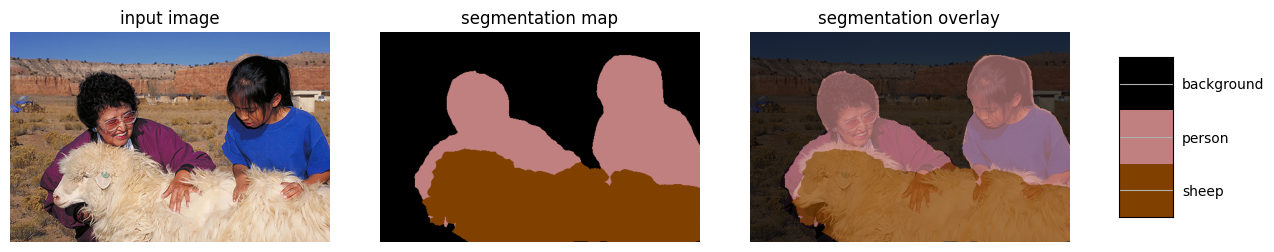

In [5]:
run_visualization("https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true")

**Using the mobilenetv2_coco_voctrainaug model**


In [6]:
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME2],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true...


<ipython-input-2-bd915aa87df3>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


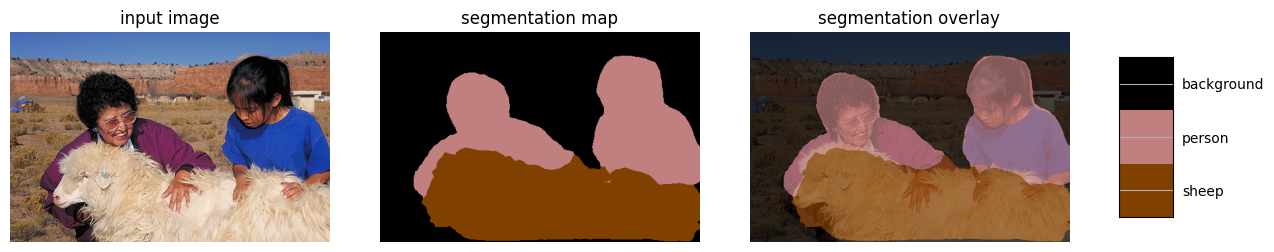

In [7]:
run_visualization("https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true")

**Using the xception_coco_voctrainval model**

In [8]:
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME4],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true...


<ipython-input-2-bd915aa87df3>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


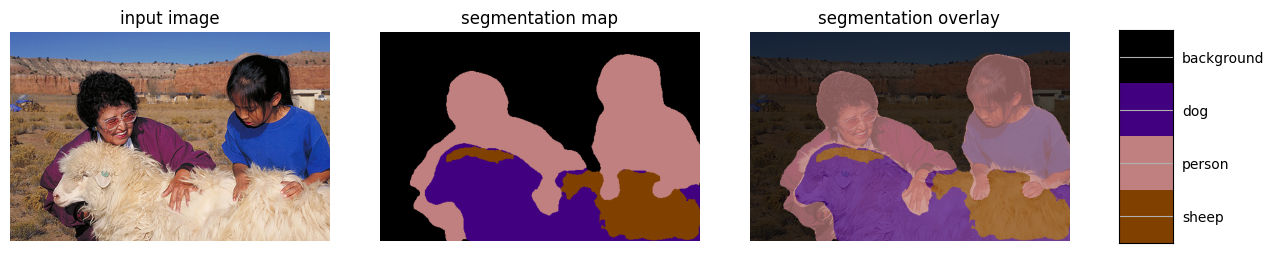

In [9]:
run_visualization("https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true")

**Using the xception_coco_voctrainaug model**

In [10]:
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME3],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

download completed! loading DeepLab model...
model loaded successfully!


running deeplab on image https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true...


<ipython-input-2-bd915aa87df3>:46: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


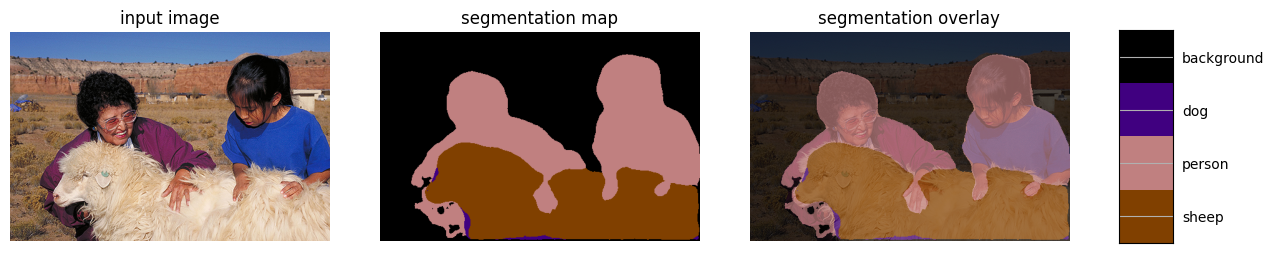

In [11]:
run_visualization("https://github.com/cagBRT/computer-vision/blob/master/images/Navajo_people_and_sheep.jpg?raw=true")

# **Assignment**
1.Select an image from https://github.com/cagBRT/computer-vision/tree/master/images
2. Select "Download"
3. Copy the url
4. Paste the url into the code and add ?raw=true to the end of the url
5. Run the four different segmentation models on your image
